In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("C:/Users/Razer PC/Downloads/credit.csv")
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


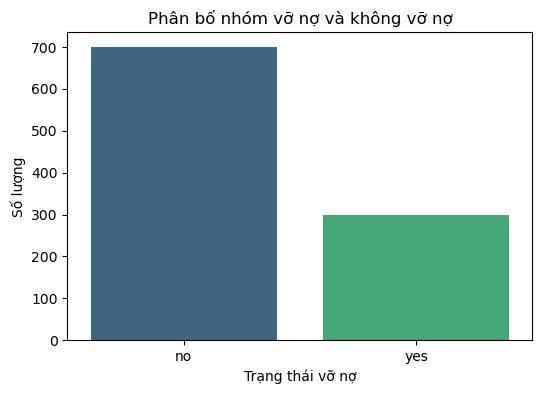

In [6]:
# Kiểm tra sự cân bằng giữa nhóm vỡ nợ và không vỡ nợ
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="default", hue="default", palette="viridis", legend=False)
plt.title("Phân bố nhóm vỡ nợ và không vỡ nợ")
plt.xlabel("Trạng thái vỡ nợ")
plt.ylabel("Số lượng")
plt.show()

Text(0, 0.5, 'Tần suất')

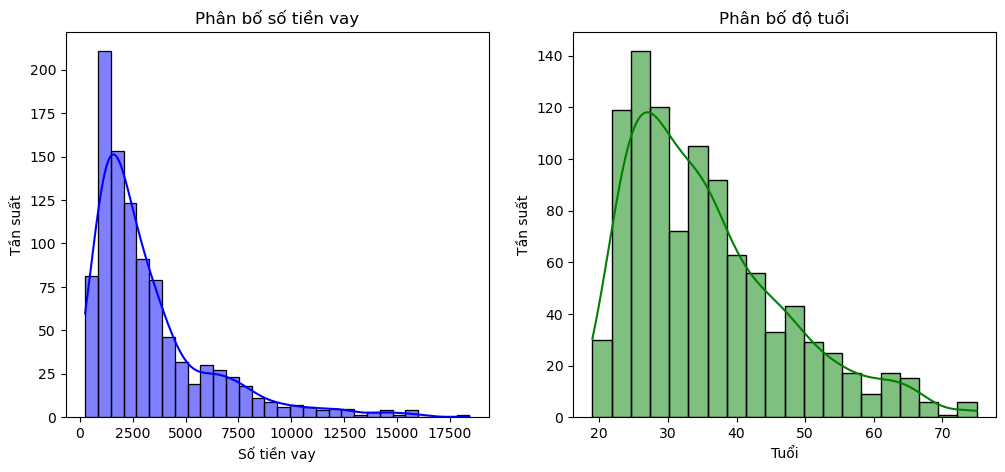

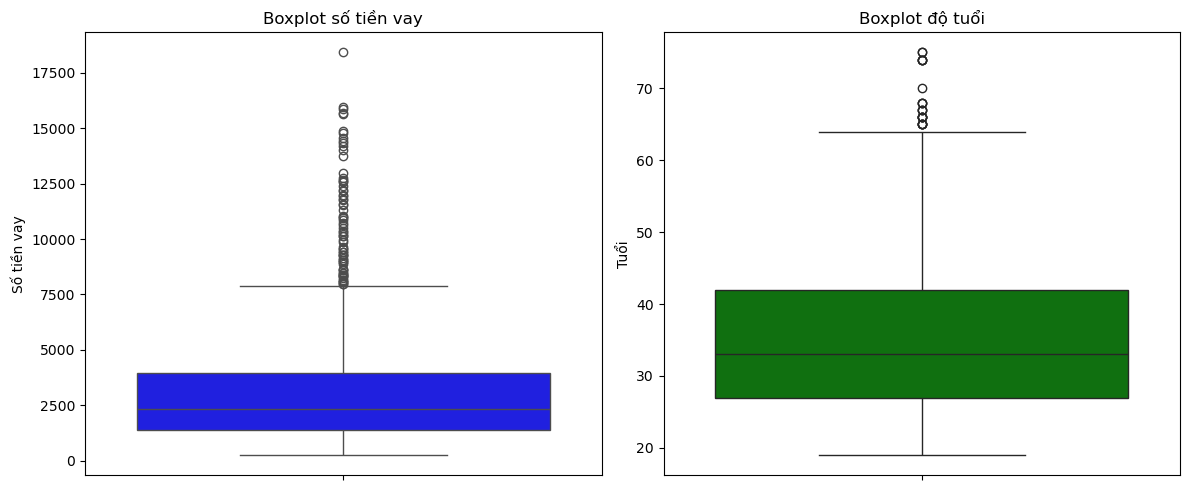

In [7]:
# Boxplot để phát hiện outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=df["amount"], ax=axes[0], color="blue")
axes[0].set_title("Boxplot số tiền vay")
axes[0].set_ylabel("Số tiền vay")

sns.boxplot(y=df["age"], ax=axes[1], color="green")
axes[1].set_title("Boxplot độ tuổi")
axes[1].set_ylabel("Tuổi")

plt.tight_layout()
plt.show()

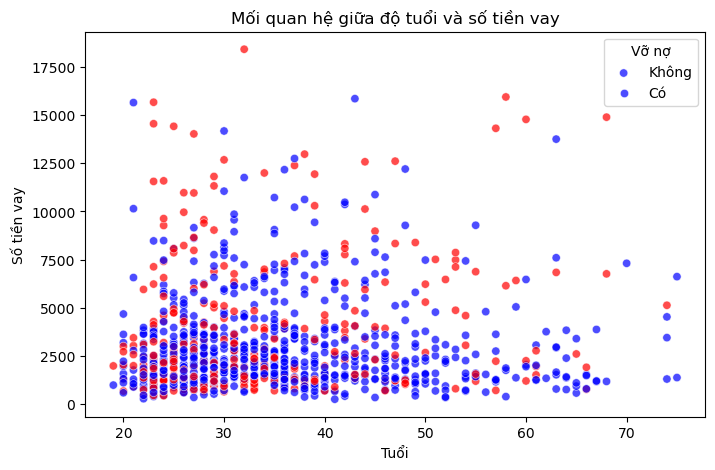

In [8]:
# Scatter plot giữa số tiền vay và tuổi
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="age", y="amount", hue="default", alpha=0.7, palette=["blue", "red"])
plt.title("Mối quan hệ giữa độ tuổi và số tiền vay")
plt.xlabel("Tuổi")
plt.ylabel("Số tiền vay")
plt.legend(title="Vỡ nợ", labels=["Không", "Có"])
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
#xử lí missing value
df.dropna(inplace=True)

# Xử lý outliers bằng IQR
for col in ["amount", "age"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


In [10]:
# Mã hóa biến categorical
label_enc = LabelEncoder()
df["default"] = label_enc.fit_transform(df["default"])

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != "default":
        df[col] = label_enc.fit_transform(df[col])

In [11]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
numeric_cols = ["amount", "age"]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [23]:
# Chia tập dữ liệu thành train và test (70/30)
X = df.drop(columns=["default"])
y = df["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
# Huấn luyện mô hình hồi quy logistic với số lần lặp cao hơn
model = LogisticRegression(max_iter=500, solver='lbfgs')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]



In [19]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7647
Precision: 0.6383
Recall: 0.3896
F1-score: 0.4839


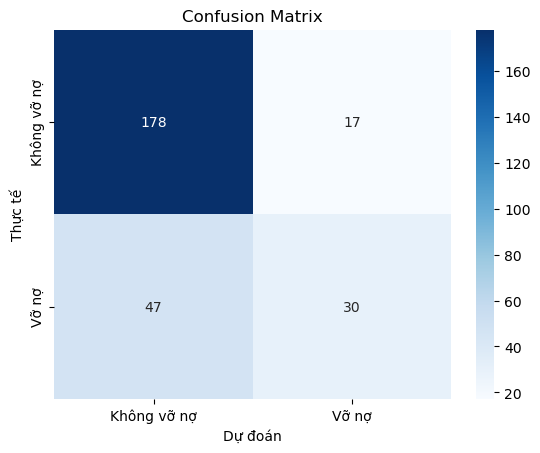

In [20]:
# Vẽ confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Không vỡ nợ', 'Vỡ nợ'], yticklabels=['Không vỡ nợ', 'Vỡ nợ'])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix")
plt.show()

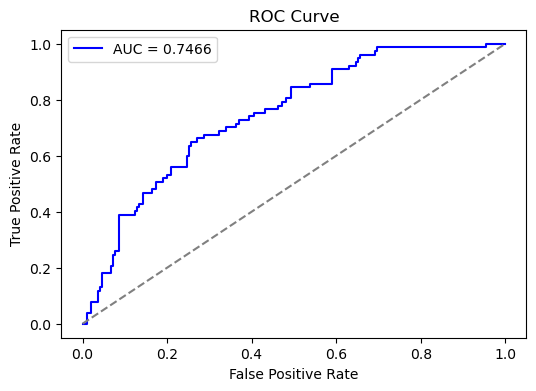

In [21]:
# Vẽ ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
# Xác định đặc trưng quan trọng
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print("Đặc trưng quan trọng nhất:")
print(feature_importance)

Đặc trưng quan trọng nhất:
credit_history          0.418225
dependents              0.266714
housing                 0.238438
percent_of_income       0.188356
employment_duration     0.080800
months_loan_duration    0.037211
existing_loans_count   -0.001877
years_at_residence     -0.011770
amount                 -0.026191
purpose                -0.027375
job                    -0.055342
savings_balance        -0.122374
age                    -0.184666
other_credit           -0.191398
phone                  -0.433429
checking_balance       -0.512051
dtype: float64
